In [1]:
import pandas as pd
from os import listdir
from pandas.errors import EmptyDataError
from unidecode import unidecode
import seaborn as sns
import re
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance

sns.set(
    rc = {
        'figure.figsize': (10, 8)
    },
    style = 'darkgrid'
)

# Dictionaries

In [2]:
grouping_orders = {
    "website": {
        "columns_before": ['website', 'sentiment'],
        "groupby": ["website"],
        "columns_after": ['fakt', 'gazeta', 'wyborcza'] 
    },
    "brand": {
        "columns_before": ['brand', 'sentiment'],
        "groupby": ["brand"],
        "columns_after": ['agora', 'ringier'] 
    },
    "country": {
        "columns_before": ['country', 'sentiment'],
        "groupby": ["country"],
        "columns_after": ['de/ch', 'pl'] 
    }
}

In [3]:
brand_keys = {
    "pl": {
        "agora": ['wyborcza', 'gazeta']
    },
    "de/ch": {
        "ringier": ['fakt', 'onet', 'newsweek']
    },
    'us': {
        "discovery": ['tvn']
    }
}

In [4]:
osoba = ['ideał', 'wróg'] # wzór, wróg, nieprzyjaciel
partia = ['postęp', 'zacofanie'] # rozwój, dobrobyt, 
poglad = ['swoboda', 'reżim'] # chaos, totalitaryzm, racjonalizm
kraj = ['sojusznik', 'wróg'] # ostoja, oaza, 
keyword_reference_words = {
    'sąd': ['sprawiedliwość', 'niesprawiedliwość'],
    'imigranci': ['przyjaciele', 'wrogowie'],
    'ekologia': ['', ''],
    'emigracja': ['szansa', 'ucieczka'], # szansa
    'pis': partia,
    'platforma': partia,
    'duda': osoba,
    'morawiecki': osoba,
    'szydło': osoba,
    'kaczyński': osoba,
    'kwaśniewski': osoba,
    'lewica': poglad,
    'prawica': poglad,
    'lgbt': ['tolerancja', ''],
    'europa': ['wspólnota', 'podział'], # rozłam
    'rosja': kraj,
    'stany': kraj,
    'premier': osoba,
    'prezydent': osoba,
    'opozycja': partia,
    'rząd': partia,
    'sejm': partia,
    'polska': ['oaza', ''],
    'putin': ['sojusznik', 'wróg'],
    'trump': ['sojusznik', 'wróg'],
    'ukraina': kraj,
    'media': ['', ''],
    'bank': ['bezpieczeństwo', 'wyzysk'],
    'niemcy': kraj,
    'papież': osoba,
    'kościół': ['oparcie', 'firma'],
    'korwin': osoba,
    'rydzyk': osoba,
    'feminizm': ['równość', 'patriarchat'],
    'leszek+miller': osoba,
}

In [5]:
decoder = {
    '%B1': 'ą',
    '%BF': 'ż',
    '%B3': 'ł',
    '%B6': 'ś',
    '%F1': 'ń',
    '%F3': 'ó'
}
with open('keywords', 'r') as f:
    raws = f.read().split('\n')
keyword_dict = {}
for raw in raws:
    tmp_keyword = raw
    for d1, d2 in decoder.items():
        tmp_keyword = tmp_keyword.replace(d1, d2)
    keyword_dict[tmp_keyword] = ''

In [6]:
keyword_regex = {
    'pis': r"\Dpis\D|prawo i sprawiedliwość"
}

# Read data

## Wyborcza

In [7]:
wyborcza_articles = []
for filename in listdir('data/wyborcza/articles'):
    try:
        wyborcza_articles.append(pd.read_csv('data/wyborcza/articles/'+filename, header = None))
    except EmptyDataError:
        pass # empty file
wyborcza_articles = pd.concat(wyborcza_articles)
wyborcza_articles.columns = ['url', 'title', 'short', 'long', 'img', 'com']
wyborcza_articles['short'] = wyborcza_articles['short'].str.replace(r'(.|..)\n', '')
wyborcza_articles = wyborcza_articles[~wyborcza_articles['long'].str.contains('W odpowiedzi do @', na = False) == True]
wyborcza_articles = wyborcza_articles[['title', 'short', 'long']]
wyborcza_articles = wyborcza_articles.dropna()
wyborcza_articles = wyborcza_articles[wyborcza_articles['title'].duplicated() == False]
wyborcza_articles = wyborcza_articles[wyborcza_articles['short'] != '0']
wyborcza_articles['website'] = 'wyborcza'
wyborcza_articles['brand'] = 'agora'
wyborcza_articles['country'] = 'pl'

In [8]:
wyborcza_articles = wyborcza_articles[
    (
        wyborcza_articles['title'] + ' ' +
        wyborcza_articles['long'] + ' ' +
        wyborcza_articles['short'] 
    ).str.contains(r""+"|".join(list(keyword_reference_words.keys())).replace('+', ' ')) == True
]

In [9]:
len(wyborcza_articles)

36486

In [10]:
wyborcza_articles.sample(5).head(5)

,title,short,long,website,brand,country
65,Jak żyją najbogatsi łodzianie,W Łódzkiem jest ok. 20 tys. bogatych ludzi. Za...,W MultiBanku majętni stanowią ok. 8 proc. klie...,wyborcza,agora,pl
248,Komisja Europejska wydaje nowe zalecenia ws. p...,1- Nowa ustawa nie rozwiązała problemu Trybuna...,"Frans Timmermans, pierwszy wiceszef Komisji Eu...",wyborcza,agora,pl
1,Pijana rowerzystka butelką wódki chciała przek...,47-letnia kobieta kierowała rowerem w stanie n...,W środę policjanci otrzymali anonimowe zgłosze...,wyborcza,agora,pl
35,Rada Regionów KOD nie chce publicznych wypowie...,Tymczasowa Rada Regionów KOD zaapelowała w sob...,Oświadczenie TRR KOD to reakcja na ujawnienie ...,wyborcza,agora,pl
399,Akcja Gazety. Ponad 15 tysięcy w pięć dni,"""Choinkę darczyńców"" dla podopiecznych Fundacj...",W piątek na konto fundacji prowadzącej domowe ...,wyborcza,agora,pl


## Gazeta

In [11]:
gazeta_articles = []
for filename in listdir('data/gazeta/articles'):
    try:
        gazeta_articles.append(pd.read_csv('data/gazeta/articles/'+filename, header = None))
    except EmptyDataError:
        pass # empty file
gazeta_articles = pd.concat(gazeta_articles)
gazeta_articles.columns = ['url', 'title', 'short', 'long', 'img', 'com']
gazeta_articles = gazeta_articles[['title', 'short', 'long']]
gazeta_articles = gazeta_articles[gazeta_articles['title'].duplicated() == False]
gazeta_articles['website'] = 'gazeta'
gazeta_articles['brand'] = 'agora'
gazeta_articles['country'] = 'pl'

In [12]:
len(gazeta_articles)

12075

In [13]:
gazeta_articles.sample(5).head()

,title,short,long,website,brand,country
96,Kto jest oskarżony?,NaN,"W PRL Rada Państwa była fasadowym ciałem, któr...",gazeta,agora,pl
38,"Po 1,5 roku wyszedł z aresztu i złożył ślubowa...",Na piątkowej nadzwyczajnej sesji rady gminy śl...,"Zbigniew Wojtera wyszedł z aresztu w Wigilię, ...",gazeta,agora,pl
20,"Oto narodowcy, którzy zapewne wejdą do Sejmu z...",Część biorących miejsc na listach Pawła Kukiza...,Chcesz wiedzieć szybciej? Polub nas\nListy Paw...,gazeta,agora,pl
121,Dwaj oszuści z Bielan w rękach kryminalnych,"Kryminalni z Bielan zatrzymali oszustów, którz...",Artur G. i Rafał G. zostali rozpoznani przez p...,gazeta,agora,pl
75,"Bridget Jones powraca. Odchudzona, samotna i.....","W sieci zadebiutował zwiastun ""Bridget Jones's...",W nowym filmie Bridget Jones jest czterdziesto...,gazeta,agora,pl


## Fakt

In [14]:
fakt_articles = []
for filename in listdir('data/fakt/articles'):
    tmp_df = pd.read_csv('data/fakt/articles/'+filename, header = None)
    tmp_df.columns = ['url', 'title', 'short', 'long', 'img', 'com',]
    tmp_df[filename] = 1
    tmp_df[filename] = tmp_df[filename].fillna(0)
    fakt_articles.append(tmp_df)
fakt_articles = pd.concat(fakt_articles, sort = False)
fakt_articles = fakt_articles[~fakt_articles['long'].isna()]
fakt_articles['long'] = fakt_articles.apply(lambda x: x['long'][len(x['short']):], axis = 1)
fakt_articles = fakt_articles[['title', 'short', 'long']]
fakt_articles = fakt_articles[fakt_articles['title'].duplicated() == False]
fakt_articles['website'] = 'fakt'
fakt_articles['country'] = 'de/ch'
fakt_articles['brand'] = 'ringier'
fakt_articles = fakt_articles.dropna()

In [15]:
len(fakt_articles)

19165

In [16]:
fakt_articles.head(3)

,title,short,long,website,country,brand
0,Pierwsze posiedzenie Sejmu. Przemówienie Andrz...,Pierwsze posiedzenie Sejmu otworzył marszałek ...,Andrzej Duda wygłosił orędzie na inauguracyjn...,fakt,de/ch,ringier
1,"Jędraszewski o gender, LGBT i karcie WHO: ""Obł...",Abp. Marek Jędraszewski wygłosił kazanie podcz...,Homilii arcybiskupa Marka Jędraszewskiego słu...,fakt,de/ch,ringier
2,"Hołownia zdradził, ile do tej pory wyłożył z w...",Szymon Hołownia w niedzielę ogłosił swój start...,Szymon Hołownia w miniony weekend w Teatrze S...,fakt,de/ch,ringier


## Onet

In [17]:
onet_articles = []
for filename in listdir('data/onet/articles'):
    tmp_df = pd.read_csv('data/onet/articles/'+filename, header = None)
    try:
        tmp_df.columns = ['url', 'title', 'short', 'long', 'img', 'com',]
    except:
        tmp_df.columns = ['title', 'short', 'long', 'img', 'com',]
    # tmp_df[filename] = 1
    onet_articles.append(tmp_df)
onet_articles = pd.concat(onet_articles, sort = False)
onet_articles = onet_articles[['title', 'short', 'long']]
onet_articles = onet_articles[onet_articles['title'].duplicated() == False]
onet_articles = onet_articles.dropna()
onet_articles['website'] = 'onet'
onet_articles['country'] = 'de/ch'
onet_articles['brand'] = 'ringier'

In [18]:
len(onet_articles)

12968

In [19]:
onet_articles.head(3)

,title,short,long,website,country,brand
0,Sondaż IBRiS dla Onetu. Spadają notowania Andr...,Prezydent Andrzej Duda cieszy się najwyższym z...,Andrzej Duda od wielu miesięcy cieszy się najw...,onet,de/ch,ringier
1,Bogdan Klich: to wielki strategiczny błąd prez...,- Decyzja wycofania polskich wojsk z Iraku pow...,- Głos opozycji jest niezbędny i trzeba go wys...,onet,de/ch,ringier
2,Izraelskie media informują o decyzji prezydent...,Izraelskie media informują za agencjami prasow...,"Andrzej Duda, którego nie poproszono o wystąpi...",onet,de/ch,ringier


## Newsweek

In [20]:
newsweek_articles = []
for filename in listdir('data/newsweek/articles'):
    tmp_df = pd.read_csv('data/newsweek/articles/'+filename, header = None)
    tmp_df.columns = ['title', 'short', 'long', 'img', 'com',]
    newsweek_articles.append(tmp_df)
newsweek_articles = pd.concat(newsweek_articles, sort = False)
newsweek_articles = newsweek_articles[['title', 'short', 'long']]
newsweek_articles = newsweek_articles[newsweek_articles['title'].duplicated() == False]
newsweek_articles = newsweek_articles.dropna()
newsweek_articles['website'] = 'newsweek'
newsweek_articles['country'] = 'de/ch'
newsweek_articles['brand'] = 'ringier'

In [21]:
len(newsweek_articles)

1605

In [22]:
newsweek_articles.head(3)

,title,short,long,website,country,brand
0,"OPINIA\nPiS tak zohydza Unię Europejską, że wk...",Prezes Jarosław Kaczyński chce stworzyć nowe z...,Spektakl zatytułowany „zła unia” miał w minion...,newsweek,de/ch,ringier
1,"„Jestem przekonany, że Biedroń będzie gryzł tr...",Jedną nogą w Brukseli Robert Biedroń chce walc...,"Po niedzielnej konwencji w Słupsku, na której ...",newsweek,de/ch,ringier
2,Andrzej Duda walczy o wyborców Konfederacji?„N...,"– Mam nadzieję, że mimo huraganowych ataków, k...",Kampania prezydencka jeszcze się nie rozpoczęł...,newsweek,de/ch,ringier


## TVN

In [23]:
tvn_articles_list = []
for filename in listdir('data/tvn/articles'):
    tmp_df = pd.read_csv('data/tvn/articles/'+filename, header = None)
    tmp_df.columns = ['title', 'short', 'long', 'img', 'com',]
    tvn_articles_list.append(tmp_df)
tvn_articles = pd.concat(tvn_articles_list, sort = False)
tvn_articles = tvn_articles[['title', 'short', 'long']]
tvn_articles = tvn_articles[tvn_articles['title'].duplicated() == False]
tvn_articles = tvn_articles.dropna()
tvn_articles['website'] = 'tvn'
tvn_articles['country'] = 'us'
tvn_articles['brand'] = 'discovery'

In [24]:
len(tvn_articles)

35232

In [25]:
tvn_articles.sample(5).head()

,title,short,long,website,country,brand
597,"""Nie ma zgody na takie metody"". Awantura na ob...","""ORMO, ZOMO, cenzura"", ""Nie ma zgody na takie ...",Autor: TVN24,tvn,us,discovery
406,Do Rosji trafiło mięso sprzed 36 lat,"Nie tylko do Polski trafiało stare, klikudzies...","Jak poinformował portal internetowy GZT.ru, mi...",tvn,us,discovery
155,"""Szanowny Panie Gistapo""","Program ""Czarno na białym"" TVN24 pokazał donos...","""Szanowna Władzo! Proszę przeprowadzić rewizje...",tvn,us,discovery
756,Grabarczyk zrezygnował z członkostwa w komitec...,Cezary Grabarczyk złożył rezygnację z członkos...,Grabarczyk jest wiceszefem PO i członkiem zarz...,tvn,us,discovery
636,Pierwszy papież na Cyprze,Papież Benedykt XVI wylądował po południu na p...,Główne cele 16. zagranicznej podróży papieża t...,tvn,us,discovery


## Sputnik

In [33]:
sputnik_list = []
for filename in listdir('data/sputnik/articles'):
    tmp_df = pd.read_csv('data/sputnik/articles/'+filename, header = None)
    tmp_df.columns = ['title', 'short', 'long', 'img', 'com',]
    sputnik_list.append(tmp_df)
sputnik_articles = pd.concat(sputnik_list, sort = False)
sputnik_articles = sputnik_articles[['title', 'short', 'long']]
sputnik_articles = sputnik_articles[sputnik_articles['title'].duplicated() == False]
sputnik_articles = sputnik_articles.dropna()
sputnik_articles['website'] = 'sputnik'
sputnik_articles['country'] = 'ru'
sputnik_articles['brand'] = 'rossija_sjegodnia'

In [34]:
len(sputnik_articles)

1089

In [35]:
sputnik_articles.sample(5).head()

,title,short,long,website,country,brand
16,Burdel Ziobry,"Trudno inaczej nazwać to, co minister chce nam...",©\n AFP 2019 / WOJTEK RADWA...,sputnik,ru,rossija_sjegodnia
297,Prowokacje na Krymie: Ukraińcy strzelają do ro...,Ostrzelanie rosyjskiej platformy wiertniczej T...,©\n AP Photo / Czarek Sokol...,sputnik,ru,rossija_sjegodnia
547,Polska starzeje się szybciej niż Unia Europejska,Polskie społeczeństwo starzeje się w szybszym ...,"Choć Polska nie jest wyjątkiem, wiele krajów r...",sputnik,ru,rossija_sjegodnia
48,Grupa Wyszechradzka: spór starej i nowej Europ...,Nadzwyczajny szczyt Grupy Wyszechradzkiej w sp...,Ten szczyt to reakcja na agresywne ataki stary...,sputnik,ru,rossija_sjegodnia
114,Rosja: 6 lat kolonii karnej dla świadka Jehowy,Sąd w Tomsku skazał lidera lokalnej komórki Św...,Sąd w Tomsku skazał lidera lokalnej komórki Św...,sputnik,ru,rossija_sjegodnia


In [36]:
sputnik_articles.head(5).values

array([['W Dumie odpowiedziano ukraińskim nacjonalistom, którzy chcą „przyswoić” rosyjskie ziemie',
        'Deputowany Dumy Państwowej Rusłan Balbek skomentował oświadczenie lidera ukraińskiej nacjonalistycznej partii „Swoboda” Oleha Tiahniboka o „przynależności” do Kijowa szeregu ziem rosyjskich i polskich.',
        'Parlamentarzysta skrytykował ukraińskich nacjonalistów za nadmierne „apetyty”. „Z takim apetytem to\xa0i całej planety okaże się za mało. Ich zdaniem, słowo "Ukraina" powinno wykraczać poza nasz Układ Słoneczny”\xa0— powiedział poseł. ©\n                    Zdjęcie : Public DomainSekrety stalinowskiej drogi śmierci za kołem podbiegunowymWedług niego, na takich radykalnych stwierdzeniach wychowuje się nowe pokolenie Ukraińców, „przekonane, że cały świat powinien nazywać się Ukraina”. Wcześniej Oleh Tiahnibok oświadczył, że terytorium Ukrainy w granicach z 1921 roku było 1,6 razy większe niż obecnie. Ponadto, wśród ziem, na które mógłby pretendować Kijów, nacjonalista wym

## Concentrate data

In [26]:
df = pd.concat([
    wyborcza_articles,
    gazeta_articles,
    fakt_articles,
    onet_articles,
    newsweek_articles,
    tvn_articles
], axis = 0, sort = False)

In [27]:
df.sample(3).head(3)

,title,short,long,website,brand,country
291,"Jedyny ""krytyk"" Putina w Dumie: Działania Rosj...",- Obecne działania naszej Dumy mogą sprowokowa...,W czwartek 20 marca Duma przyjęła wcześniejszą...,tvn,discovery,us
82,Leszczyński Akwawit ma nowego właściciela,Leszczyńskie przedsiębiorstwo Akwawit należy j...,Przedsiębiorstwo Przemysłu Fermentacyjnego Akw...,wyborcza,agora,pl
477,Słynna bielska wytwórnia walczy z piractwem. U...,Studio Filmów Rysunkowych uruchomiło własny ka...,Studio Filmów Rysunkowych to jedna z najsłynni...,wyborcza,agora,pl


## Data check

In [28]:
df.sample(1).values

array([['Kaczyński o dzieciach, które są "przedmiotem eksperymentów"',
        'Sobota to dzień obfitujący w polityczne wydarzenia. Partie nie próżnują na chwilę przed wyborami do PE. Swoje konwencje zaplanowały PiS, KE i Wiosna Biedronia. Jarosław Kaczyński mówił o "seksualizowaniu dzieci od kołyski" i ataku na Kościół. - Żaden pedofil nie schowa się w żadnej kurii ani partii. Wybaczcie emocje, ale sam jestem ojcem - grzmiał z kolei Grzegorz Schetyna. Wszystkie wystąpienia liderów, także Roberta Biedronia, pośrednio nawiązywały do dokumentu Tomasza Sekielskiego o pedofilii w polskim Kościele, który dziś ma swoją premierę w internecie.',
        ' O 10 wystartowały konwencje PiS w Bydgoszczy i KE w Płocku, a o 11 - Wiosny w Poznaniu. Prezes PiS Jarosław Kaczyński mówił o obronie prawa rodziców do wychowania dzieci. - By nie były seksualizowane niemal od kołyski. Żeby nie wprowadzano tych programów wychowawczych, które będą degenerować. By istniało w Polsce prawo do tego, by istniała no

In [29]:
df['long'] = df['long'].str.replace('\n\n', ' ').str.replace('\n', ' ')

## Data summary

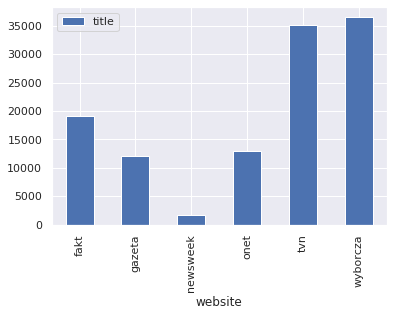

In [30]:
df\
    [['website', 'title']]\
    .groupby('website')\
    .count()\
    .plot(kind = 'bar')

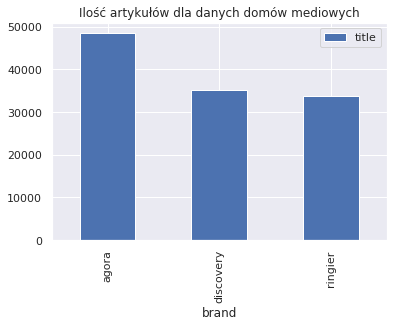

In [31]:
df\
    [['brand', 'title']]\
    .groupby('brand')\
    .count()\
    .plot(kind = 'bar', title = 'Ilość artykułów dla danych domów mediowych')

# Write

In [31]:
len(df)

108933

In [35]:
for i, tmp_df in enumerate(np.array_split(df, 10)):
    tmp_df.to_csv('data/concatenated/'+str(i), index = False)